In [36]:
# PyTorch
import torch
import torch.nn as nn
from torch_geometric.data import Data

import numpy as np
from scipy.stats import qmc
import pandas as pd
import meshio
import json
import os

# Matplotlib
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.tri as tri
import matplotlib.ticker as ticker

from typing import List, Tuple, Dict

In [2]:
# CUDA support
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(f"Using device: {device}")
print(torch.cuda.get_device_name(torch.cuda.current_device()))  # GPU name

Using device: cuda
NVIDIA GeForce RTX 2060


In [3]:
class DNN(nn.Module):
    """
    Simple feed-forward network with tanh activations between hidden layers
    and Xavier initialization
    """
    def __init__(self, layers: List[int]) -> None:
        super(DNN, self).__init__()

        if len(layers) < 2:
            raise ValueError("`layers` must contain at least input and output sizes.")

        modules = []
        # Build hidden layers with tanh activations
        for in_dim, out_dim in zip(layers[:-2], layers[1:-1]):
            modules.append(nn.Linear(in_dim, out_dim))
            modules.append(nn.Tanh())
        # Final output layer (no activation)
        modules.append(nn.Linear(layers[-2], layers[-1]))

        self.network = nn.Sequential(*modules)

        # Xavier initialize all layers
        for layer in self.network:
            if isinstance(layer, nn.Linear):
                nn.init.xavier_uniform_(layer.weight)
                if layer.bias is not None:
                    nn.init.zeros_(layer.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)

In [4]:
class PINN():
    """
    Physics-Informed Neural Network for plane stress in a metal plate.
    Approximates five outputs, u, v, sigma_xx, sigma_yy, sigma_xy, from two inputs x and y.
    """
    def __init__(self, dnn: torch.nn.Module) -> None:
        """
        Args:
            dnn: The deep neural network used to approximate the solution.
        """

        # Tracks the loss in every epoch
        self.track_loss = []

        # Learning rates
        self.lr_adam = 0.01
        self.lr_lbfgs = 0.005

        # Deep Neural Network
        self.dnn = dnn

        # Optimizer
        self.optimizer_lbfgs = torch.optim.LBFGS(
            self.dnn.parameters(),
            lr=self.lr_lbfgs,
            max_iter=20000,
            max_eval=20000,
            history_size=200,
            tolerance_grad=1e-10,
            tolerance_change=1e-10,
        )
        self.iter = 0
        self.optimizer_adam = torch.optim.Adam(self.dnn.parameters(), lr=self.lr_adam)
        
        # Scheduler for the Adam optimizer
        self.scheduler = torch.optim.lr_scheduler.StepLR(self.optimizer_adam, step_size=4000, gamma=0.5)


    def set_var(
        self, 
        X: np.ndarray, 
        Y: np.ndarray, 
        masks: Dict[str, np.ndarray], 
        h: float, 
        l: float, 
        r: float, 
        nu: float
    ) -> None:
        """
        Set input variables and boundary masks.
        Args:
            X: x-coordinates for collocation points.
            Y: y-coordinates for collocation points.
            masks: Dictionary of boolean masks that define the points for each boundary region.
            h: Height of the plate.
            l: Lenght of the plate.
            r: radius of the hole.
            nu: Poisson's ratio.
        """
        assert 'left' in masks and 'top' in masks and 'right' in masks and 'down' in masks and 'hole' in masks, \
            "Mask dictionary must contain keys: 'left', 'top', 'right', 'down', 'hole'."
        
        self.x = torch.tensor(X, requires_grad=True).float().to(device).view(-1, 1)
        self.y = torch.tensor(Y, requires_grad=True).float().to(device).view(-1, 1)
        self.data = torch.cat((self.x, self.y), dim=1)

        self.mask_left = masks['left']
        self.mask_top = masks['top']
        self.mask_right = masks['right']
        self.mask_down = masks['down']
        self.mask_hole = masks['hole']

        self.nu = nu
        self.h = h
        self.l = l
        self.r = r

    def model_value(self, data: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
        """
        Evaluate the model's predicted output variables at given points.
        Args:
            data: Input tensor of shape (N, 2) with x and y coordinates.
        Returns:
            Tuple: u, v, sigma_xx, sigma_yy, sigma_xy
        """
        out = self.dnn(data)
        u = out[:,0:1]
        v = out[:,1:2]
        sxx = out[:,2:3]
        syy = out[:,3:4]
        sxy = out[:,4:5]
        return u, v, sxx, syy, sxy

    def pde_loss(
        self, 
        u: torch.Tensor, 
        v: torch.Tensor, 
        sxx: torch.Tensor, 
        syy: torch.Tensor, 
        sxy: torch.Tensor, 
        data: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute the PDE residual loss.
        Args:
            u, v, sxx, syy, sxy:  Output values from the model.
            data: Input coordinates. 
        Returns:
            Tensor: Mean squared residual loss.
        """

        # Gradient of the displacement
        du = torch.autograd.grad(u, data, torch.ones_like(u), create_graph=True)[0]
        dv = torch.autograd.grad(v, data, torch.ones_like(v), create_graph=True)[0]
        
        dx_u, dy_u = du[:, 0:1], du[:, 1:2]
        dx_v, dy_v = dv[:, 0:1], dv[:, 1:2]

        # Gradient of the stress
        dx_sxx = torch.autograd.grad(sxx, data, torch.ones_like(sxx), create_graph=True)[0][:, 0:1]
        dy_syy = torch.autograd.grad(syy, data, torch.ones_like(syy), create_graph=True)[0][:, 1:2]
        dsxy = torch.autograd.grad(sxy, data, torch.ones_like(sxy), create_graph=True)[0]
        dx_sxy = dsxy[:, 0:1]
        dy_sxy = dsxy[:, 1:2]

        # PDE residual
        term_xx = 1 / (1 - self.nu**2) * (dx_u + self.nu*dy_v)
        term_yy = 1 / (1 - self.nu**2) * (dy_v + self.nu*dx_u)
        term_xy = 1 / (2*(1 + self.nu)) * (dy_u + dx_v)

        r1 = torch.mean(torch.pow((sxx - term_xx), 2))
        r2 = torch.mean(torch.pow((syy - term_yy), 2))
        r3 = torch.mean(torch.pow((sxy - term_xy), 2))
        r4 = torch.mean(torch.pow((dx_sxx + dy_sxy), 2))
        r5 = torch.mean(torch.pow((dy_syy + dx_sxy), 2))

        residual = r1 + r2+ r3 + r4 + r5
        return residual

    def bc_loss(
        self, 
        u: torch.Tensor, 
        v: torch.Tensor, 
        sxx: torch.Tensor, 
        syy: torch.Tensor, 
        sxy: torch.Tensor, 
        data: torch.Tensor
    ) -> torch.Tensor:
        """
        Compute boundary condition loss.
        Args:
            u, v, sxx, syy, sxy: Output values from the model.
            data: Input coordinates.
        Returns:
            Tensor: Mean squared boundary loss
        """

        # Left boundary condition
        b = torch.mean(torch.pow(u[self.mask_left], 2))
        b += torch.mean(torch.pow(v[self.mask_left], 2))

        # Top boundary condition
        b += torch.mean(torch.pow(syy[self.mask_top], 2))
        b += torch.mean(torch.pow(sxy[self.mask_top], 2))

        # Right boundary condition
        b += torch.mean(torch.pow(sxx[self.mask_right] - 1, 2))
        b += torch.mean(torch.pow(sxy[self.mask_right], 2))

        # Bottom boundary condition
        b += torch.mean(torch.pow(syy[self.mask_down], 2))
        b += torch.mean(torch.pow(sxy[self.mask_down], 2))

        # Hole boundary condition
        x = data[:, 0:1]
        y = data[:, 1:2]
        nx = -(x[self.mask_hole]-self.l/2)/self.r
        ny = -(y[self.mask_hole]-(self.h/2))/self.r
        tx = torch.mul(sxx[self.mask_hole], nx) + torch.mul(sxy[self.mask_hole], ny)
        ty = torch.mul(sxy[self.mask_hole], nx) + torch.mul(syy[self.mask_hole], ny)

        b += torch.mean(torch.pow(tx, 2))
        b += torch.mean(torch.pow(ty, 2))

        return b

    
    def loss_func(self) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Compute both PDE and boundary condition losses.
        Returns:
            Tuple[Tensor, Tensor]: PDE loss and boundary condition loss.
        """
        u, v, sxx, syy, sxy = self.model_value(self.data)
        pde = self.pde_loss(u, v, sxx, syy, sxy, self.data)
        bc = self.bc_loss(u, v, sxx, syy, sxy, self.data)
        return pde, bc


    def lbfgs_func(self) -> torch.Tensor:
        """
        Closure for L-BFGS optimizer.
        Returns:
            Tensor: Total loss.
        """
        pde_loss, bc_loss = self.loss_func()
        loss = pde_loss + bc_loss

        self.optimizer_lbfgs.zero_grad()
        loss.backward()
        self.track_loss.append(loss.item())

        if self.iter % 100 == 0:
            print(f"Iter: {self.iter}, Loss: {'{:e}'.format(loss.item())}")
        self.iter += 1

        return loss
    
    def train(self, epochs: int=1000) -> None:
        """
        Train the model using Adam and L-BFGS optimizer.
        Args:
            epochs: Number of epochs for the Adam optimizer.
        """
        self.dnn.train()

        for epoch in range(epochs):
            pde_loss, bc_loss = self.loss_func()
            loss = pde_loss + bc_loss

            # Backpropagation
            self.optimizer_adam.zero_grad()
            loss.backward()
            self.optimizer_adam.step()

            # Scheduler
            self.scheduler.step()
            self.track_loss.append(loss.item())

            if epoch % 100 == 0:
                print(f"Epoch {epoch}, Loss: {'{:e}'.format(loss.item())}")
                print(f"PDE: {'{:e}'.format(pde_loss.item())}, BC: {'{:e}'.format(bc_loss.item())}")

        # Move to the L-BFGS optimizer
        self.optimizer_lbfgs.step(self.lbfgs_func)


    def predict(self, x: np.ndarray, y: np.ndarray) -> Tuple:
        """
        Get the network prediction at given coordinates.
        Args:
            x: Array of x-coordinates.
            y: Array of y-coordinates.
        Returns:
            Tuple: u, v, sigma_xx, sigma_yy, sigma_xy as arrays.
        """
        x = torch.tensor(x, dtype=torch.float, device=device).view(-1, 1)
        y = torch.tensor(y, dtype=torch.float, device=device).view(-1, 1)
        data = torch.cat((x, y), dim=1)

        self.dnn.eval()
        with torch.no_grad():
            u, v, sxx, syy, sxy = self.model_value(data)
        return (
            u.cpu().numpy(), 
            v.cpu().numpy(), 
            sxx.cpu().numpy(), 
            syy.cpu().numpy(), 
            sxy.cpu().numpy()
        )

In [5]:
def generate_points(
    n_d: int,
    n_b: int,
    domain_bounds: List[Tuple[int, int]], 
    holes: List[Tuple[int, int, int]],
    seed: int
) -> Tuple[np.ndarray, np.ndarray, Dict[str, np.ndarray]]:
    """
    Generates collocation points for the metal plate with a hole in the center
    Args:
        n_d: Number of interior domain points.
        n_b: Number of boundary points per edge/hole.
        domain_bounds: Defines the rectangle in the format, [(x_min, x_max), (y_min, y_max)].
        holes: A list containing coordinates and radius for each hole, (center_x, center_y, radius).
        seed: A seed to use in the samplers.
    Returns:
        Tuple: Two arrays of x- and y-coordinates and Dict of masks that define each bounadary 
    """

    x_min, x_max = domain_bounds[0]
    y_min, y_max = domain_bounds[1]

    # Create samplers
    sampler_2d = qmc.LatinHypercube(d=2, seed=seed)
    sampler_1d = qmc.LatinHypercube(d=1, seed=seed)

    # Generate valid domain points using Latin Hypercube Sampling and hole rejection
    factor = 1.5
    while True:
        m = int(n_d * factor)
        u = sampler_2d.random(m)
        pts = qmc.scale(u, [x_min, y_min], [x_max, y_max])

        # Filter out points inside any hole
        mask = np.ones(len(pts), dtype=bool)
        for cx, cy, r in holes:
            dist2 = (pts[:, 0] - cx) ** 2 + (pts[:, 1] - cy) ** 2
            mask &= dist2 > r ** 2

        valid_pts = pts[mask]
        if len(valid_pts) >= n_d:
            dom = valid_pts[:n_d]
            break
        factor *= 1.5  # Increase oversampling

    dom_x, dom_y = dom[:, 0], dom[:, 1]

    # Boundary: straight edges
    points  = sampler_1d.random(n_b)

    left_x  = np.full(n_b, x_min)
    left_y  = qmc.scale(points, y_min, y_max).flatten()

    top_x   = qmc.scale(points, x_min, x_max).flatten()
    top_y   = np.full(n_b, y_max)

    right_x = np.full(n_b, x_max)
    right_y = qmc.scale(points, y_min, y_max).flatten()

    down_x  = qmc.scale(points, x_min, x_max).flatten()
    down_y  = np.full(n_b, y_min)

    # Boundary: hole (assumes one circular hole)
    cx, cy, r = holes[0]
    theta = qmc.scale(points, 0, 2 * np.pi).flatten()
    hole_x = cx + r * np.cos(theta)
    hole_y = cy + r * np.sin(theta)

    # Combine domain + boundaries
    dom_x = np.hstack((dom_x, hole_x, left_x, top_x, right_x, down_x))
    dom_y = np.hstack((dom_y, hole_y, left_y, top_y, right_y, down_y))

    # Masks
    mask_left  = np.isclose(dom_x, x_min)
    mask_top   = np.isclose(dom_y, y_max)
    mask_right = np.isclose(dom_x, x_max)
    mask_down  = np.isclose(dom_y, y_min)
    rad1 = np.sqrt((dom_x - cx)**2 + (dom_y - cy)**2)
    mask_hole  = np.isclose(rad1, r)
    
    masks = {
        'left': mask_left,
        'top': mask_top,
        'right': mask_right,
        'down': mask_down,
        'hole': mask_hole
    }

    return dom_x, dom_y, masks

In [ ]:
# Parameters of the metal plate
l = 2.0
h = 1.0 
r = 0.10
nu = 0.33
seed = 123

domain_bounds = [(0, l), (0, h)]
hole = [(l/2, h/2, r)]

# Collocation points
X, Y, masks = generate_points(50000, 2000, domain_bounds, hole, seed)

# Size of network
nodes = 64
layers = [2] + 6 * [nodes] + [5]

In [7]:
# Extracting masks from the Dict
mask_left = masks["left"]
mask_top = masks["top"]
mask_right = masks["right"]
mask_down = masks["down"]
mask_hole = masks["hole"]

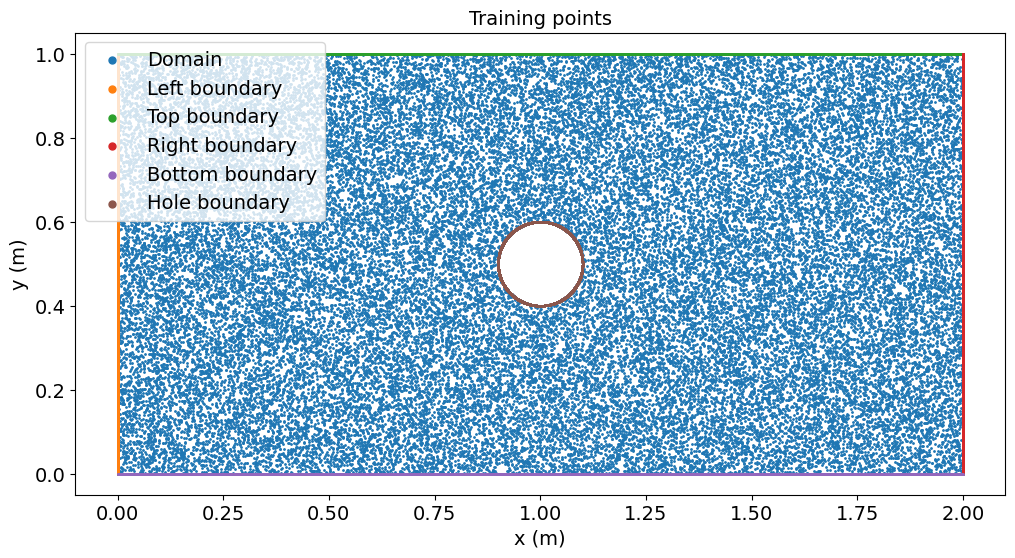

In [8]:
# Plotting the collocation points

rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14,
})

plt.figure(figsize=(12, 6))

plt.scatter(X, Y, label="Domain", s=1)
plt.scatter(X[mask_left], Y[mask_left], label="Left boundary", s=1)
plt.scatter(X[mask_top], Y[mask_top], label="Top boundary", s=1)
plt.scatter(X[mask_right], Y[mask_right], label="Right boundary", s=1)
plt.scatter(X[mask_down], Y[mask_down], label="Bottom boundary", s=1)
plt.scatter(X[mask_hole], Y[mask_hole], label="Hole boundary", s=1)
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.title("Training points")
plt.legend(markerscale=5, loc="upper left")
plt.show()

In [9]:
# Create the DNN
model = DNN(layers).to(device)

In [10]:
# Create the PINN and set the parameters
pinn = PINN(model)
pinn.set_var(X, Y, masks, h, l, r, nu)

In [12]:
# Train the model
pinn.train(10000)

Epoch 0, Loss: 7.837989e-01
PDE: 1.073480e-01, BC: 6.764508e-01
Epoch 100, Loss: 1.641312e-01
PDE: 4.988760e-02, BC: 1.142436e-01
Epoch 200, Loss: 1.409167e-01
PDE: 4.080372e-02, BC: 1.001130e-01
Epoch 300, Loss: 1.285679e-01
PDE: 3.683105e-02, BC: 9.173689e-02
Epoch 400, Loss: 1.334100e-01
PDE: 4.692335e-02, BC: 8.648665e-02
Epoch 500, Loss: 1.045253e-01
PDE: 4.227845e-02, BC: 6.224688e-02
Epoch 600, Loss: 1.061976e-01
PDE: 4.068677e-02, BC: 6.551084e-02
Epoch 700, Loss: 8.335350e-02
PDE: 4.193357e-02, BC: 4.141994e-02
Epoch 800, Loss: 7.730664e-02
PDE: 3.889762e-02, BC: 3.840902e-02
Epoch 900, Loss: 6.173036e-02
PDE: 3.453193e-02, BC: 2.719843e-02
Epoch 1000, Loss: 6.260542e-02
PDE: 3.444250e-02, BC: 2.816291e-02
Epoch 1100, Loss: 5.699717e-02
PDE: 3.217668e-02, BC: 2.482049e-02
Epoch 1200, Loss: 6.262203e-02
PDE: 3.355843e-02, BC: 2.906360e-02
Epoch 1300, Loss: 5.307211e-02
PDE: 2.997536e-02, BC: 2.309675e-02
Epoch 1400, Loss: 5.273124e-02
PDE: 2.950982e-02, BC: 2.322142e-02
Epoch 1

In [ ]:
# Save model
torch.save(pinn.dnn.state_dict(), "../models/both_6_64.pth")

In [20]:
# Load a model if necessary
model = DNN(layers).to(device)
model.load_state_dict(torch.load("../models/both_6_64.pth", weights_only=True))
pinn = PINN(model)

In [ ]:
def create_graph(mesh_file: str, csv_file: str, feature_column: str = "Von Mises Stress") -> Tuple[Data, torch.Tensor, torch.Tensor]:
    """
    Creates a graph structure from a mesh along with the values and coordinates of every node
    Args:
        mesh_file: filename and location of the file containing the mesh (.inp format)
        csv_file: filename and location of the data file from Ansys (.csv format)
        feature_column: The chosen column of data in the csv file
    Returns:
        data: The graph objects that represents the mesh
        pos: An 2-dimensional array of the coordiantes of every node
        node_features: An array containing the chosen result in every node
    """
    # Read mesh and CSV data
    mesh = meshio.read(mesh_file)
    df = pd.read_csv(csv_file, sep=',', skipinitialspace=True)

    nodes = mesh.points[:, :2]
    values = df[feature_column].values
    num_nodes = len(nodes)
    node_features = torch.tensor(values[:num_nodes], dtype=torch.float).view(-1, 1)

    # Generate edges from triangle elements
    edges = []
    for cell in mesh.cells:
        if cell.type == "triangle":
            for element in cell.data:
                i, j, k = element
                edges.extend([
                    [i, j], [j, i],
                    [j, k], [k, j],
                    [k, i], [i, k]
                ])
    edges = torch.tensor(edges, dtype=torch.long).t().contiguous()

    # Create graph data object
    pos = torch.tensor(nodes, dtype=torch.float)
    data = Data(x=node_features, edge_index=edges, pos=pos)

    return data, pos, node_features

In [22]:

mesh_file = "../../Ansys/mesh_files/middle_r10_o1.inp"
csv_file = "../../Ansys/data/middle_r10.csv"

# Feature to extract from csv file
feature_column = "Von Mises Stress"

data, pos, node_features = create_graph(mesh_file, csv_file, feature_column)
print(data.x.shape)

torch.Size([5529, 1])


In [28]:
x = pos[:, 0:1].detach().cpu().numpy()
y = pos[:, 1:2].detach().cpu().numpy()

u, v, sxx, syy, sxy = pinn.predict(x, y)

E = 7e10  # Young's modulus (Pa)
sigma_0 = 50e6  # Applied stress (Pa)

U = sigma_0 / E

# Scale the field variables
u = u*U
v = v*U
sxx = sxx*sigma_0
syy = syy*sigma_0
sxy = sxy*sigma_0
von_mises = np.sqrt(sxx**2 + syy**2 - sxx*syy + 3*sxy**2)
fem_result = node_features.detach().cpu().numpy()

In [29]:
# Calculating the normalized L2-error
l2_error = np.linalg.norm(von_mises - fem_result) / np.linalg.norm(fem_result, 2)
print(l2_error)

0.018353967


In [ ]:
# Plot the loss value throughout the training
loss = pinn.track_loss

plt.semilogy(loss)
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.grid()
plt.show()

In [ ]:
# Save the loss data inside a json file
file_name = '../loss_data/optimization.json'
new_run = {"run_id": "both", "values": loss}  # New run data

# Load existing data if the file exists
if os.path.exists(file_name):
    with open(file_name, 'r') as f:
        data = json.load(f)
else:
    data = {}

# Add the new run (using a unique key, e.g., run identifier)
data[new_run["run_id"]] = new_run["values"]

# Save back to the JSON file
with open(file_name, 'w') as f:
    json.dump(data, f, indent=2)


In [34]:
# Parameters for increasing the font size in the plot
rcParams.update({
    'font.size': 20,
    'axes.titlesize': 20,
    'axes.labelsize': 20,
    'xtick.labelsize': 18,
    'ytick.labelsize': 18,
})

In [38]:
# Interpolate the points into a surface where and creating a mask for the hole
triang = tri.Triangulation(x.flatten(), y.flatten())

x_tri = x.flatten()[triang.triangles].mean(axis=1)
y_tri = y.flatten()[triang.triangles].mean(axis=1)

hole_center = (1.0, 0.5)
hole_radius = 0.10

dist = (x_tri - hole_center[0])**2 + (y_tri - hole_center[1])**2
mask = (dist < hole_radius**2)
triang.set_mask(mask)

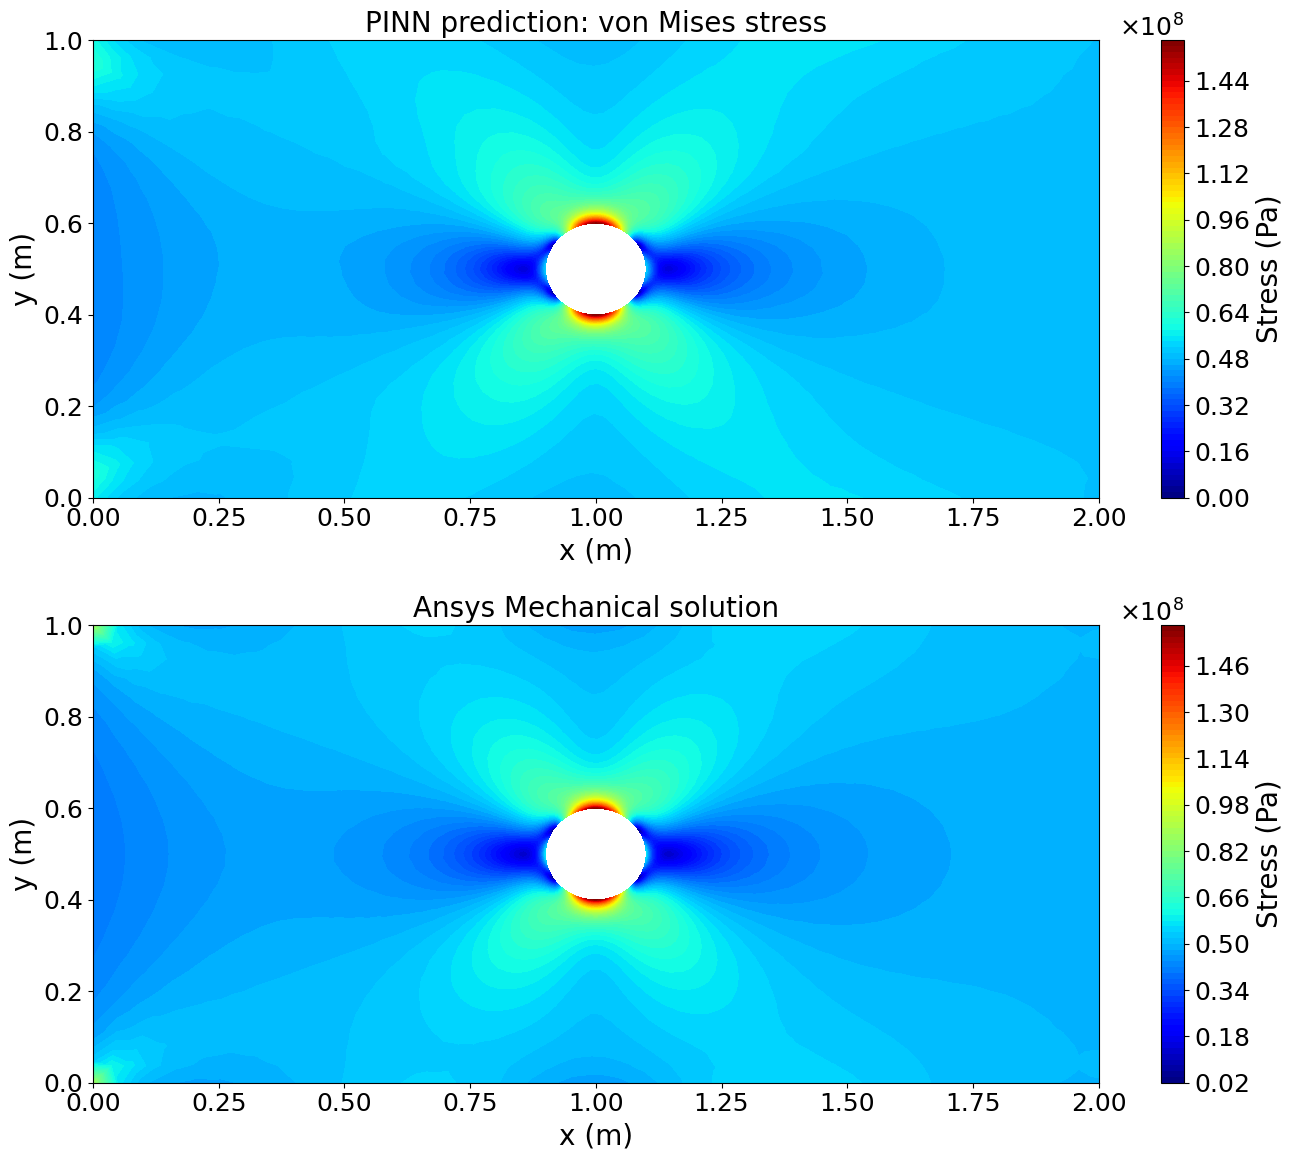

In [39]:
# Plotting the PINN prediction and result from Ansys Mechanical
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

color_map = 'jet'
color_map_label = "Stress (Pa)"

sc1 = ax1.tricontourf(triang, von_mises.flatten(), levels = 100, cmap='jet')
ax1.set_title('PINN prediction: von Mises stress')
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")
cb1 = plt.colorbar(sc1)
cb1.set_label(color_map_label)

sc2 = ax2.tricontourf(triang, fem_result.flatten(), levels = 100, cmap='jet')
ax2.set_title('Ansys Mechanical solution')
ax2.set_xlabel("x (m)")
ax2.set_ylabel("y (m)")
cb2 = plt.colorbar(sc2)
cb2.set_label(color_map_label)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2, 2))  # Show sci notation for numbers < 1e-2 or > 1e2
cb1.ax.yaxis.set_major_formatter(formatter)
cb2.ax.yaxis.set_major_formatter(formatter)

plt.tight_layout()
plt.show()

In [32]:
# Calculate the stress concentration factor for the plate
sigma_max1 = np.max(von_mises)
sigma_max2 = np.max(fem_result)

k1 = sigma_max1 / sigma_0
k2 = sigma_max2 / sigma_0
print(f"SCF PINN: {k1:.3f}")
print(f"SCF Ansys:{k2:.3f}")

SCF PINN: 3.143
SCF Ansys:3.172
